In [9]:
!pip install scikit_posthocs Orange3 numpy pandas matplotlib seaborn PyQt5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.1/37.1 MB 7.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
errors_df = pd.read_csv("errors_df_2.csv")
p_value = 0

In [13]:
# Альтернативная реализация compute_CD и graph_ranks без использования Orange
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Вычисляет критическое расстояние для теста Нимени
    
    Parameters:
    avranks: средние ранги
    n: количество наблюдений
    alpha: уровень значимости
    test: тип теста
    
    Returns:
    cd: критическое расстояние
    """
    k = len(avranks)
    if alpha == "0.05":
        q = {2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164}
    elif alpha == "0.1":
        q = {2: 1.645, 3: 2.052, 4: 2.291, 5: 2.459, 6: 2.589, 7: 2.693, 8: 2.780, 9: 2.855, 10: 2.920}
    else:
        raise ValueError("alpha must be either 0.05 or 0.1")
    
    cd = q[min(k, 10)] * np.sqrt(k * (k + 1) / (6 * n))
    return cd

def manual_graph_ranks(avranks, names, cd=None, width=6, textspace=1):
    """
    Рисует диаграмму критических расстояний
    
    Parameters:
    avranks: средние ранги
    names: имена алгоритмов
    cd: критическое расстояние
    width: ширина диаграммы
    textspace: пространство для текста
    """
    # Сортировка по возрастанию ранга (лучшие слева)
    sorted_ranks = sorted([(a, i) for i, a in enumerate(avranks)])
    sorted_names = [names[i] for _, i in sorted_ranks]
    
    # Создание графика
    plt.figure(figsize=(12, 6))
    
    # Рисуем линию рангов
    yline = 0.5
    plt.axhline(y=yline, color='k', linestyle='-', linewidth=0.5)
    
    # Рисуем ранги и имена
    bigtick = 0.3
    for i, (rank, idx) in enumerate(sorted_ranks):
        plt.plot([rank], [yline], 'o', markersize=8, color='r')
        plt.text(rank, yline-bigtick/2-0.3, f"{rank:.2f}", 
                 ha='center', va='top', fontsize=10)
        plt.text(rank, yline+bigtick/2+0.1, sorted_names[idx], 
                 ha='center', va='bottom', fontsize=12)
    
    # Добавляем критическое расстояние, если указано
    if cd:
        # Рисуем группы алгоритмов, которые не имеют статистически значимых различий
        for i, (rank1, _) in enumerate(sorted_ranks):
            for j, (rank2, _) in enumerate(sorted_ranks):
                if i < j and abs(rank1 - rank2) < cd:
                    # Соединяем алгоритмы, которые не статистически различны
                    plt.plot([rank1, rank2], [yline+0.1, yline+0.1], color='k', linewidth=2.5)
        
        # Добавляем подпись с критическим расстоянием
        plt.text(0.05, 0.9, f"Critical Distance = {cd:.3f}", transform=plt.gca().transAxes,
                 fontsize=12)
    
    # Настройка графика
    plt.xlim(min(avranks)-0.5, max(avranks)+0.5)
    plt.ylim(-1, 1.5)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.title("Диаграмма критических различий", fontsize=14)
    plt.gca().invert_yaxis()  # перевернуть ось Y
    plt.gca().xaxis.tick_top()  # перенести ось X вверх
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Рейтинг')
    plt.tight_layout()
    plt.axis('off')  # отключить оси
    
    return plt

In [14]:
graph_ranks = manual_graph_ranks


Найдены статистически значимые различия между моделями

P-значения попарных сравнений:
     0    1       2       3
0  1.0  0.0  0.0000  0.0000
1  0.0  1.0  0.0000  0.0000
2  0.0  0.0  1.0000  0.0404
3  0.0  0.0  0.0404  1.0000


<Figure size 1000x600 with 0 Axes>

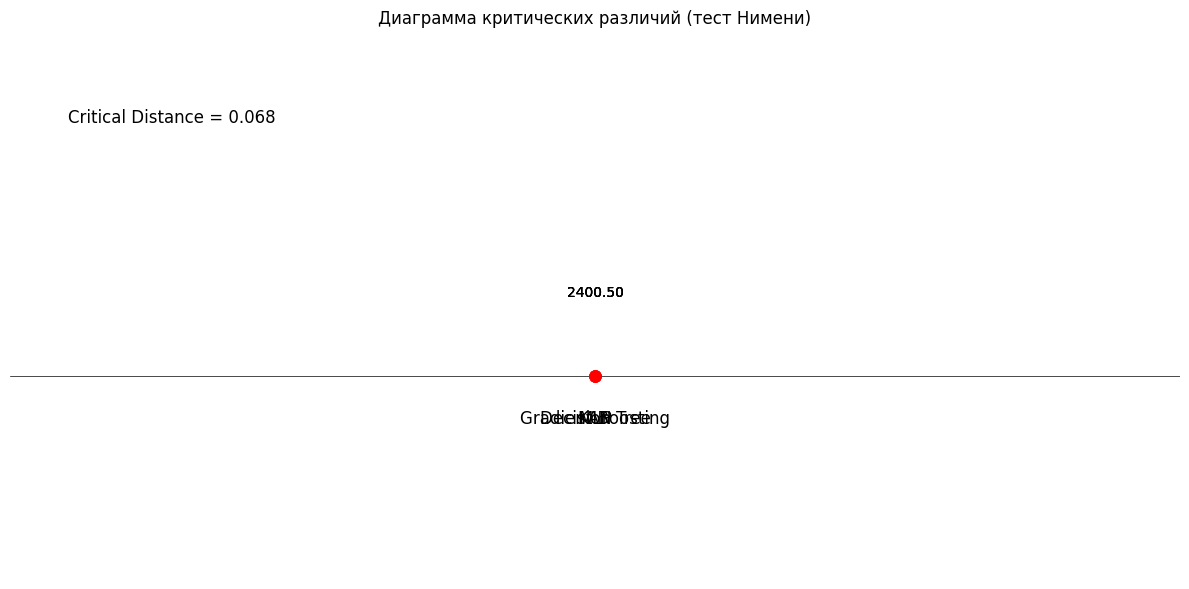

In [15]:
# Если p-value < 0.05, проведём тест Нимени
if p_value < 0.05:
    print("\nНайдены статистически значимые различия между моделями")
    
    # Подготовим массив данных для теста Нимени
    # Преобразуем DataFrame в массив numpy для использования с posthoc_nemenyi_friedman
    errors_array = np.array([errors_df['KAN'], 
                            errors_df['MLP'], 
                            errors_df['Decision Tree'],
                            errors_df['Gradient Boosting']]).T
    
    # Используем функцию posthoc_nemenyi_friedman вместо posthoc_nemenyi
    from scikit_posthocs import posthoc_nemenyi_friedman
    nemenyi_result = posthoc_nemenyi_friedman(errors_array)
    
    print("\nP-значения попарных сравнений:")
    print(nemenyi_result.round(4))
    
    # Визуализация    
    average_ranks = errors_df.rank(axis=0).mean().values
    model_names = errors_df.columns.tolist()
    cd = compute_CD(average_ranks, len(errors_df), alpha="0.05")
    
    plt.figure(figsize=(10, 6))
    graph_ranks(average_ranks, model_names, cd=cd, width=8, textspace=1.5)
    plt.title('Диаграмма критических различий (тест Нимени)')
    plt.tight_layout()
    plt.show()


Найдены статистически значимые различия между моделями

P-значения попарных сравнений:
     0    1       2       3
0  1.0  0.0  0.0000  0.0000
1  0.0  1.0  0.0000  0.0000
2  0.0  0.0  1.0000  0.0404
3  0.0  0.0  0.0404  1.0000
Критическая дистанция CD = 0.068


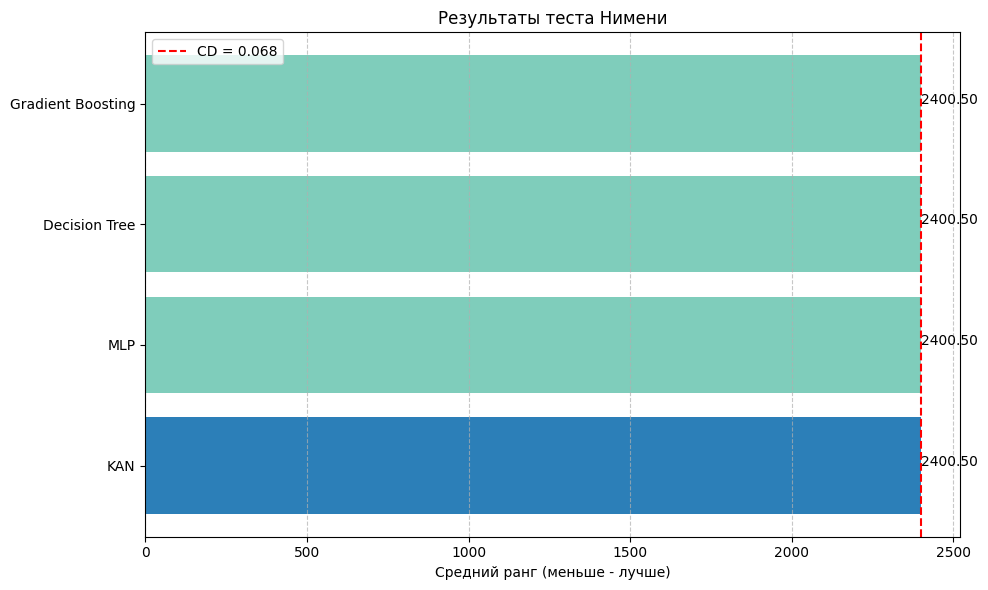

In [12]:
# Если p-value < 0.05, проведём тест Нимени
if p_value < 0.05:
    print("\nНайдены статистически значимые различия между моделями")
    
    # Подготовим массив данных для теста Нимени
    errors_array = np.array([errors_df['KAN'], 
                            errors_df['MLP'], 
                            errors_df['Decision Tree'],
                            errors_df['Gradient Boosting']]).T
    
    # Используем функцию posthoc_nemenyi_friedman
    from scikit_posthocs import posthoc_nemenyi_friedman
    nemenyi_result = posthoc_nemenyi_friedman(errors_array)
    
    print("\nP-значения попарных сравнений:")
    print(nemenyi_result.round(4))
    
    # Вычисляем средние ранги и критическую дистанцию
    average_ranks = errors_df.rank(axis=0).mean().values
    model_names = errors_df.columns.tolist()
    
    # Самостоятельно вычисляем критическую дистанцию
    k = len(average_ranks)
    n = len(errors_df)
    q_alpha_005 = {2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.949,
                  8: 3.031, 9: 3.102, 10: 3.164}
    cd = q_alpha_005[min(k, 10)] * np.sqrt(k * (k + 1) / (6.0 * n))
    
    print(f"Критическая дистанция CD = {cd:.3f}")
    
    # Альтернативная визуализация
    plt.figure(figsize=(10, 6))
    
    # Создаем DataFrame для удобства сортировки
    ranks_df = pd.DataFrame({
        'Model': model_names,
        'Rank': average_ranks
    })
    ranks_df = ranks_df.sort_values('Rank')  # меньше - лучше
    
    # Рисуем горизонтальные полосы для рангов
    colors = ['#2C7FB8' if i == 0 else '#7FCDBB' for i in range(len(ranks_df))]
    plt.barh(ranks_df['Model'], ranks_df['Rank'], color=colors)
    
    # Добавляем значения рангов на график
    for i, (model, rank) in enumerate(zip(ranks_df['Model'], ranks_df['Rank'])):
        plt.text(rank + 0.1, i, f'{rank:.2f}')
    
    # Добавляем критическую дистанцию как вертикальную линию
    plt.axvline(x=ranks_df['Rank'].iloc[0] + cd, color='red', linestyle='--',
               label=f'CD = {cd:.3f}')
    plt.legend()
    
    plt.xlabel('Средний ранг (меньше - лучше)')
    plt.title('Результаты теста Нимени')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()